## Extreme Value Theory (EVT)

EVT can be used to better estimate tail losses of portfolios. Risk measurements such as VaR and ES are poor when examining high confidence levels, e.g., 99 % or 99.9%. A solution is to better describe the tail losses with a distribution in and of itself. It is after all only the loss tail we are interested in when doing risk management. 

EVT has two apporaches:

* **Block Maximia**: Examining the largest value with a chunk of observations (e.g. with a certain fixed time period)
* **Peaks Over Threshold**: Examining the values which falls above some fixed threshold (usually the $95^{\text{th}}$ percentile of the dataset)

Both approaches rely on their respective fundamental Extreme Value Theorem. These are esoterically linked, however, in finance, and for most practical purposes, Peaks Over Threshold (POT) is more suitable and easier to implement. 

Thus, we are looking for the distribution of losses $\mathbb{P}(L \leq y + u |L>u)$ where $L$ is the loss distribution and $u$ is the $95^{\text{th}}$ percentile of some dataset $\mathcal{D} \triangleq \{r_i\}_{i=1}^n$ of returns. Using rudimentary probability theory we obtain 
$$
\mathbb{P}(L \leq y + u | L > u) = \frac{\mathbb{P}(\{L \leq y + u \} \cap \{ L> u\} )}{\mathbb{P}(L>u)}.
$$


A main result in EVT for the POT approach states that $\mathbb{P}(L \leq y + u | L > u) \approx G_{\xi, \beta}(y)$ where $G_{\xi, \beta}(y)$ is a generalized Pareto distribution (GPD). This distributions have the following expression
$$
    G_{\xi, \beta} (y) = \begin{cases} 1 - \Big[1 + \xi \frac{y}{\beta} \Big]^{-\frac{1}{\xi}}, & \xi \neq 0, \\ 1 - \textrm{exp}\Big\{-\frac{y}{\beta} \Big\}, & \xi = 0,\end{cases}
$$
with the probability density function
$$
    g_{\xi, \beta} (y) = \begin{cases} \frac{1}{\beta}\Big(1 + \xi \frac{y}{\beta} \Big)^{-\frac{1}{\xi}-1}, & \xi \neq 0, \\  \frac{1}{\beta}\textrm{exp}\Big\{-\frac{y}{\beta} \Big\}, & \xi = 0. \end{cases}
$$

Next we can derive the distribution of losses exceeding $u$ defined as $L_u$ by

$$
F_{L_u}(x) = G_{\xi, \beta}(l-u)(1 - \hat{F}_L(u)) + \hat{F}_L(u)
$$

where $\hat{F}_L(u)$ is the empirical CDF of observations below $u$.

#### 1. Setup and Data Gathering

To begin we fetch some return data of S&P500 during 07 to 17.

In [9]:
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme()
sns.set_style("whitegrid", {'grid.linestyle': '--'})
seq_col_brew = sns.color_palette("flag_r", 4)
sns.set_palette(seq_col_brew)

In [67]:
import numpy as np
from pandas_datareader import data as pdr

# Weekly data
spx_weekly = pdr.get_data_yahoo("^GSPC", start="2007-01-01", end="2022-01-01", interval="wk")
spx_weekly = spx_weekly["Adj Close"]

# Log Returns
spx_weekly_returns = np.log(spx_weekly / spx_weekly.shift(1))[1:]

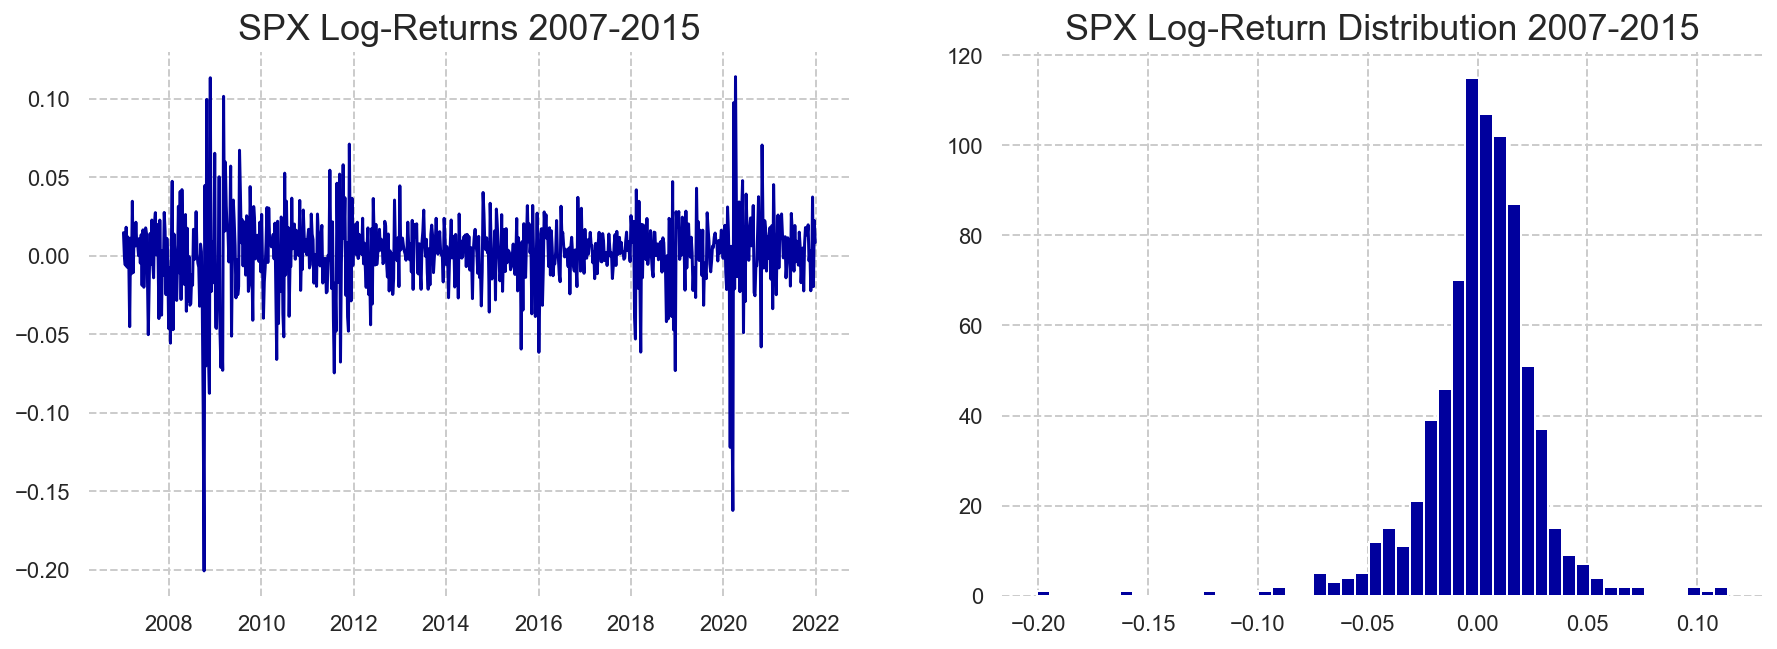

In [68]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(spx_weekly_returns)
ax[0].set_title("SPX Log-Returns 2007-2015", fontsize=18)
ax[0].set_frame_on(False)

ax[1].hist(spx_weekly_returns, bins=50)
ax[1].set_title("SPX Log-Return Distribution 2007-2015", fontsize=18)
ax[1].set_frame_on(False)
fig.set_size_inches(15, 5)
plt.show()

#### 2. Maximum Likelihood Estimation

In order to estimate the parameters $\xi$ and $\beta$ in the GPD we perform MLE with the dataset $\{l_i-u\}_{i=1}^n$. The dataset is easily found. The log-likelihood function can be written as

\begin{equation*}
    \begin{split}
        \ell(\mathbf{\theta}|x_1,\ldots, x_{N_u}) & =  -N_u\ln(\beta) - (1+\frac{1}{\xi})\sum_{i=1}^{N_u}\ln(1+\xi \frac{x_i}{\beta}).\\
    \end{split}
\end{equation*}

In this case $N_u$ is the total number of losses exceeding the threshold $u$. Moreover, there are also certain constraints on the parameters. Namely

$$
(1 + \xi \frac{x_i}{\beta}) \geq 0 \quad \forall i \in \{1,\cdots,N_u\}.
$$

In [289]:
losses = -spx_weekly_returns
u = np.quantile(losses, 0.95)
excess_losses = [l-u for l in losses if l >= u]

In [298]:
from scipy.optimize import minimize

EPSILON = 1e-16

def evt_ml_objective_function(params, data) -> float:
    n_observations = len(data)
    log_likelihood = 0

    for obs in data:
        log_likelihood = log_likelihood + np.log(1 + params[0] / params[1] * obs)

    return n_observations * np.log(params[1]) + (1 + 1 / params[0]) * log_likelihood
    
def evt_parameter_generator(excess_losses) -> list:
    cons = []
    for obs in excess_losses:
        cons.append({'type': 'ineq', 'fun': lambda x: 1 + x[0] / x[1] * obs})

    x0 = [0.1, 0.001]
    sol = minimize(evt_ml_objective_function, x0, constraints=cons, args=excess_losses)
    return sol.x

In [299]:
sol = evt_parameter_generator(excess_losses=excess_losses)
sol

/var/folders/d7/rpl_88f12ln2z1s2h4m9ybjm0000gn/T/ipykernel_54069/2880719177.py:12: RuntimeWarning: invalid value encountered in log
  return n_observations * np.log(params[1]) + (1 + 1 / params[0]) * log_likelihood
/var/folders/d7/rpl_88f12ln2z1s2h4m9ybjm0000gn/T/ipykernel_54069/2880719177.py:10: RuntimeWarning: invalid value encountered in log
  log_likelihood = log_likelihood + np.log(1 + params[0] / params[1] * obs)


array([0.26123888, 0.01846943])

#### 3. Distribution Plots

In [300]:
def generalized_pareto_distribution_pdf(x: float, xi: float, beta: float) -> float:
        if xi == 0:
                raise NotImplementedError
        else:
                return 1 / beta * (1 + xi * x /beta) ** (-1/xi - 1)

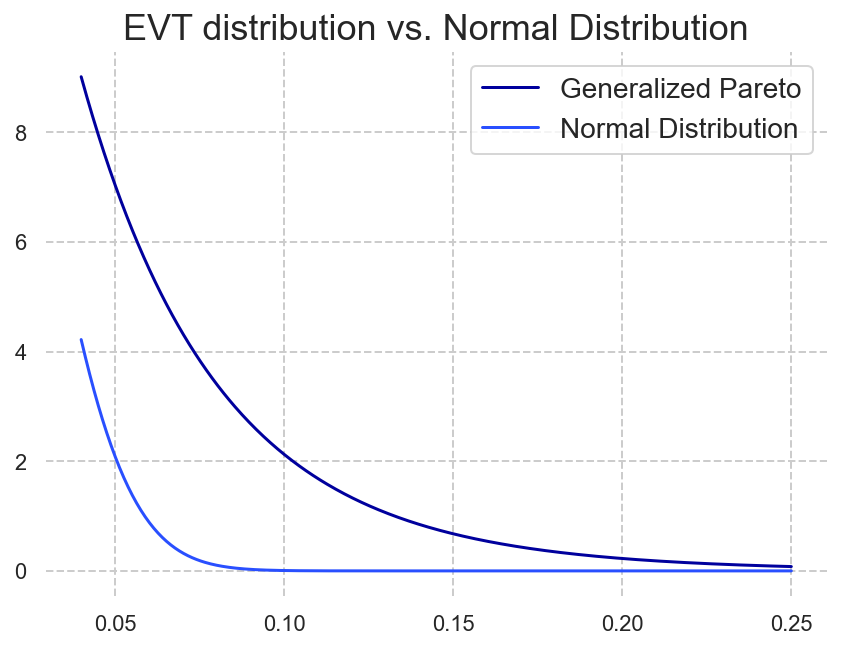

In [313]:
import scipy

x = np.linspace(u, 0.25, 500)
gpd_values = generalized_pareto_distribution_pdf(x, x[0], x[1])
norm_values = scipy.stats.norm.pdf(x, np.mean(losses), np.std(losses))

fig, ax = plt.subplots()

ax.plot(x, gpd_values, label="Generalized Pareto")
ax.plot(x, norm_values, label="Normal Distribution")
ax.set_title("EVT distribution vs. Normal Distribution", fontsize=18)
ax.set_frame_on(False)
ax.legend(fontsize=14)

fig.set_size_inches(7,5)
plt.show()

#### 4. Risk Measures: EVT vs. Vanilla

Using the newly found EVT distribution of losses above $u$ we can find Value at Risk and Expected Shortfall. Given that $\xi \neq 0$ we have
$$
\textrm{VaR}_c = u + \frac{\beta}{\xi}\Big((\frac{N}{n_u}(1-c))^{-\xi}-1 \Big),
$$

$$
\textrm{ES}_c = \frac{\textrm{VaR}_c}{1-\xi} + \frac{\beta - u\xi}{1-\xi}.
$$

We pick a confidence level of 99.9 %.

In [327]:
xi = sol[1]
beta = sol[1]

Nu = len(losses)
n = len(excess_losses)
c = 0.999

VaR = u  + beta/xi * ( (N/n * (1 - c)) ** (-xi) - 1)
ES = VaR / (1 - xi) + (beta - u * xi)/(1-xi)

In [338]:
VaR_vanilla = np.quantile(losses, c)
ES_vanilla  = np.average([l for l in losses if l >= VaR_vanilla])

In [341]:
print(f"EVT Value at risk @ {c}: " + str(np.round(VaR*100, 1)) + "%")
print(f"EVT Expected shortfall @ {c}: " + str(np.round(ES*100, 1)) + "%")
print()
print(f"Vanilla Value at Riks @ {c}: " + str(np.round(VaR_vanilla*100, 1)) + "%")
print(f"Vanilla Expected Shortfall @ {c}: " + str(np.round(ES_vanilla*100, 1)) + "%")

EVT Value at risk @ 0.999: 11.5%
EVT Expected shortfall @ 0.999: 13.6%

Vanilla Value at Riks @ 0.999: 17.1%
Vanilla Expected Shortfall @ 0.999: 20.1%
